In [32]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Conv2D
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

In [33]:
datadir = 'track2'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

/var/folders/v3/hwmt_9nx6nl41f06plb5szqr0000gn/T/ipykernel_5227/1638751974.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


center  \
0  /Users/jonathanhu/Desktop/cs4756-robot-learning-sp24/IMG/center_2024_05_08_11_41_03_784.jpg   
1  /Users/jonathanhu/Desktop/cs4756-robot-learning-sp24/IMG/center_2024_05_08_11_41_03_887.jpg   
2  /Users/jonathanhu/Desktop/cs4756-robot-learning-sp24/IMG/center_2024_05_08_11_41_03_990.jpg   
3  /Users/jonathanhu/Desktop/cs4756-robot-learning-sp24/IMG/center_2024_05_08_11_41_04_095.jpg   
4  /Users/jonathanhu/Desktop/cs4756-robot-learning-sp24/IMG/center_2024_05_08_11_41_04_195.jpg   

                                                                                         left  \
0   /Users/jonathanhu/Desktop/cs4756-robot-learning-sp24/IMG/left_2024_05_08_11_41_03_784.jpg   
1   /Users/jonathanhu/Desktop/cs4756-robot-learning-sp24/IMG/left_2024_05_08_11_41_03_887.jpg   
2   /Users/jonathanhu/Desktop/cs4756-robot-learning-sp24/IMG/left_2024_05_08_11_41_03_990.jpg   
3   /Users/jonathanhu/Desktop/cs4756-robot-learning-sp24/IMG/left_2024_05_08_11_41_04_095.jpg   
4   /Users/jonathanhu/Desktop/cs4756-robot-learning-sp24/IMG/left_2024_05_08_11_41_04_195.jpg   

                                                                                         right  \
0   /Users/jonathanhu/Desktop/cs4756-robot-learning-sp24/IMG/right_2024_05_08_11_41_03_784.jpg   
1   /Users/jonathanhu/Desktop/cs4756-robot-learning-sp24/IMG/right_2024_05_08_11_41_03_887.jpg   
2   /Users/jonathanhu/Desktop/cs4756-robot-learning-sp24/IMG/right_2024_05_08_11_41_03_990.jpg   
3   /Users/jonathanhu/Desktop/cs4756-robot-learning-sp24/IMG/right_2024_05_08_11_41_04_095.jpg   
4   /Users/jonathanhu/Desktop/cs4756-robot-learning-sp24/IMG/right_2024_05_08_11_41_04_195.jpg   

   steering  throttle  reverse     speed  
0  0.0       0.0       0.0      0.000038  
1  0.0       0.0       0.0      0.000088  
2  0.0       0.0       0.0      0.000040  
3  0.0       0.0       0.0      0.000069  
4  0.0       0.0       0.0      0.000047

In [34]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center                              left  \
0  center_2024_05_08_11_41_03_784.jpg  left_2024_05_08_11_41_03_784.jpg   
1  center_2024_05_08_11_41_03_887.jpg  left_2024_05_08_11_41_03_887.jpg   
2  center_2024_05_08_11_41_03_990.jpg  left_2024_05_08_11_41_03_990.jpg   
3  center_2024_05_08_11_41_04_095.jpg  left_2024_05_08_11_41_04_095.jpg   
4  center_2024_05_08_11_41_04_195.jpg  left_2024_05_08_11_41_04_195.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2024_05_08_11_41_03_784.jpg  0.0       0.0       0.0      0.000038  
1  right_2024_05_08_11_41_03_887.jpg  0.0       0.0       0.0      0.000088  
2  right_2024_05_08_11_41_03_990.jpg  0.0       0.0       0.0      0.000040  
3  right_2024_05_08_11_41_04_095.jpg  0.0       0.0       0.0      0.000069  
4  right_2024_05_08_11_41_04_195.jpg  0.0       0.0       0.0      0.000047

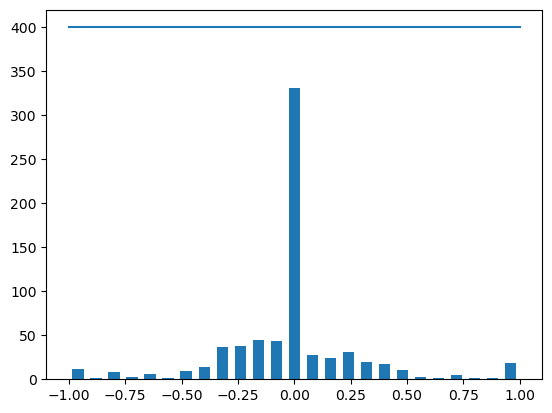

In [35]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [36]:

print('total data:', len(data))
print(data.shape)

total data: 711
(711, 7)


In [37]:
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

removed: 0
remaining: 711


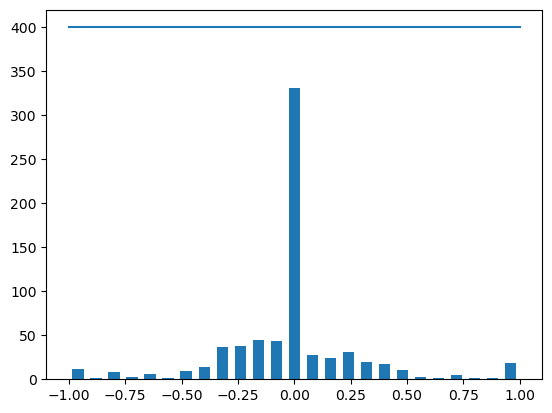

In [38]:
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [39]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

In [40]:
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

In [41]:
len(image_paths)

2133

In [42]:
len(steerings)

2133

In [43]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))
     

Training Samples: 1706
Valid Samples: 427


Text(0.5, 1.0, 'Validation set')

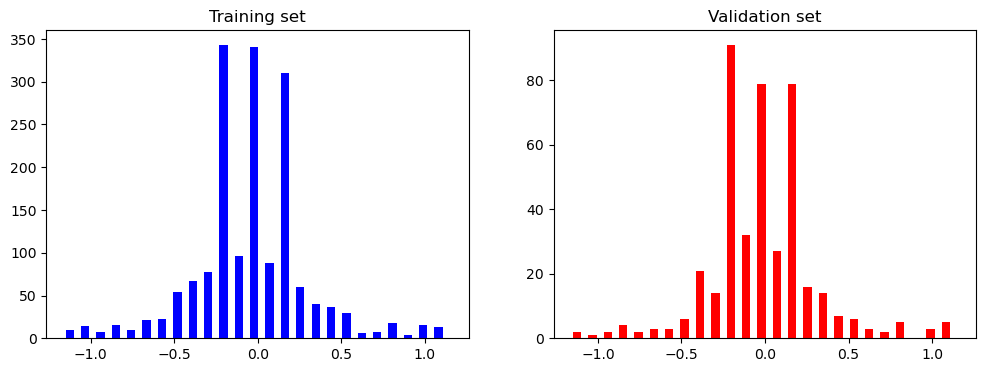

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

Text(0.5, 1.0, 'Zoomed Image')

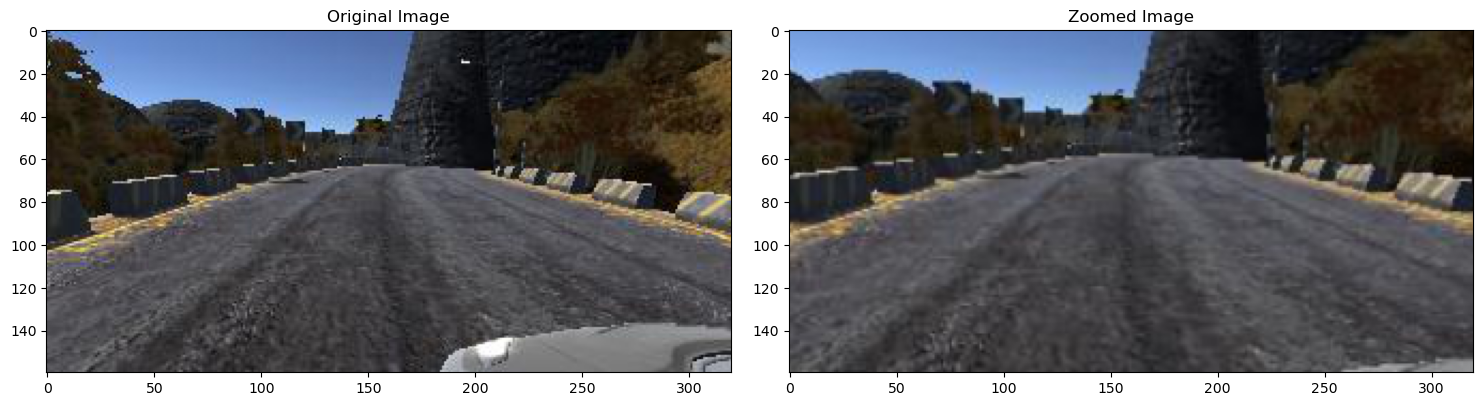

In [45]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image


image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')


Text(0.5, 1.0, 'Panned Image')

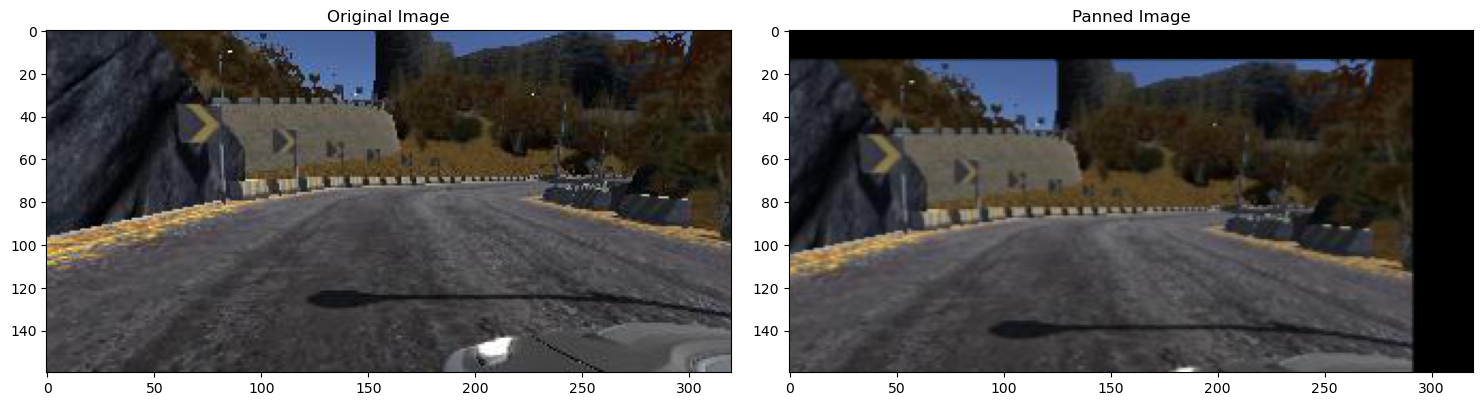

In [46]:
def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

Text(0.5, 1.0, 'Brightness altered image ')

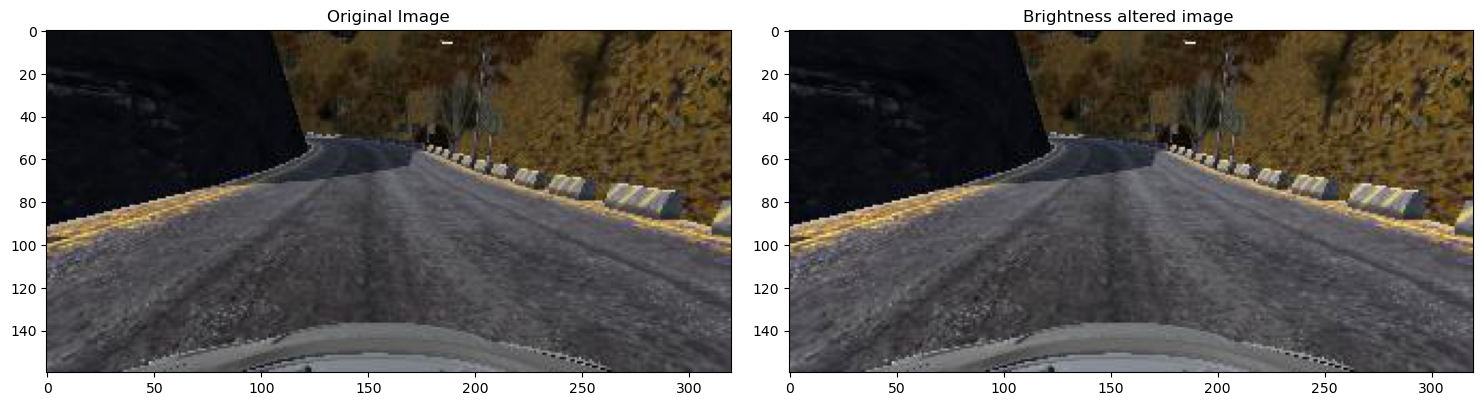

In [47]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)


fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ') 

Text(0.5, 1.0, 'Flipped Image - Steering Angle:-0.0')

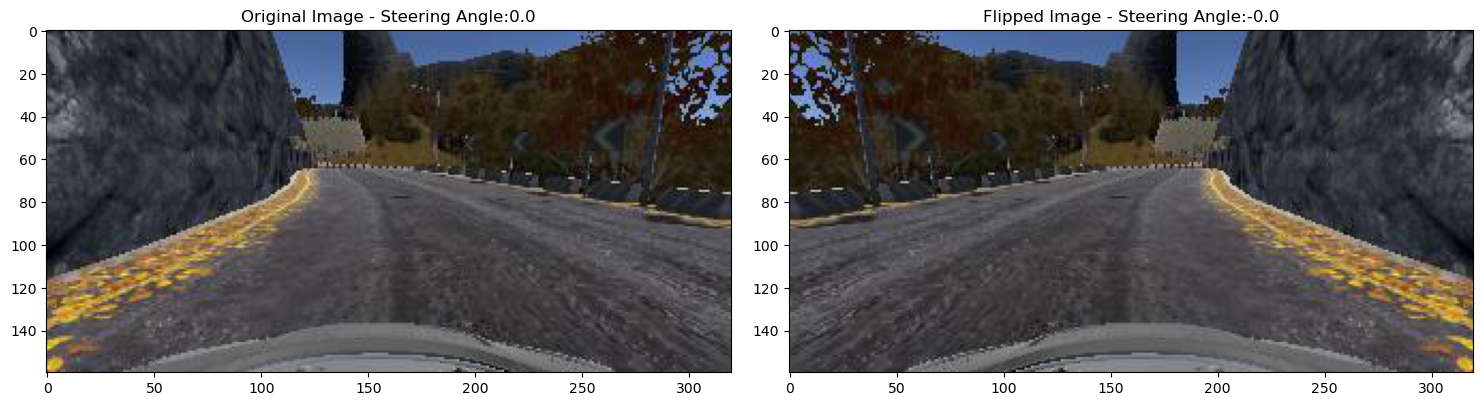

In [48]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

In [49]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)

    return image, steering_angle

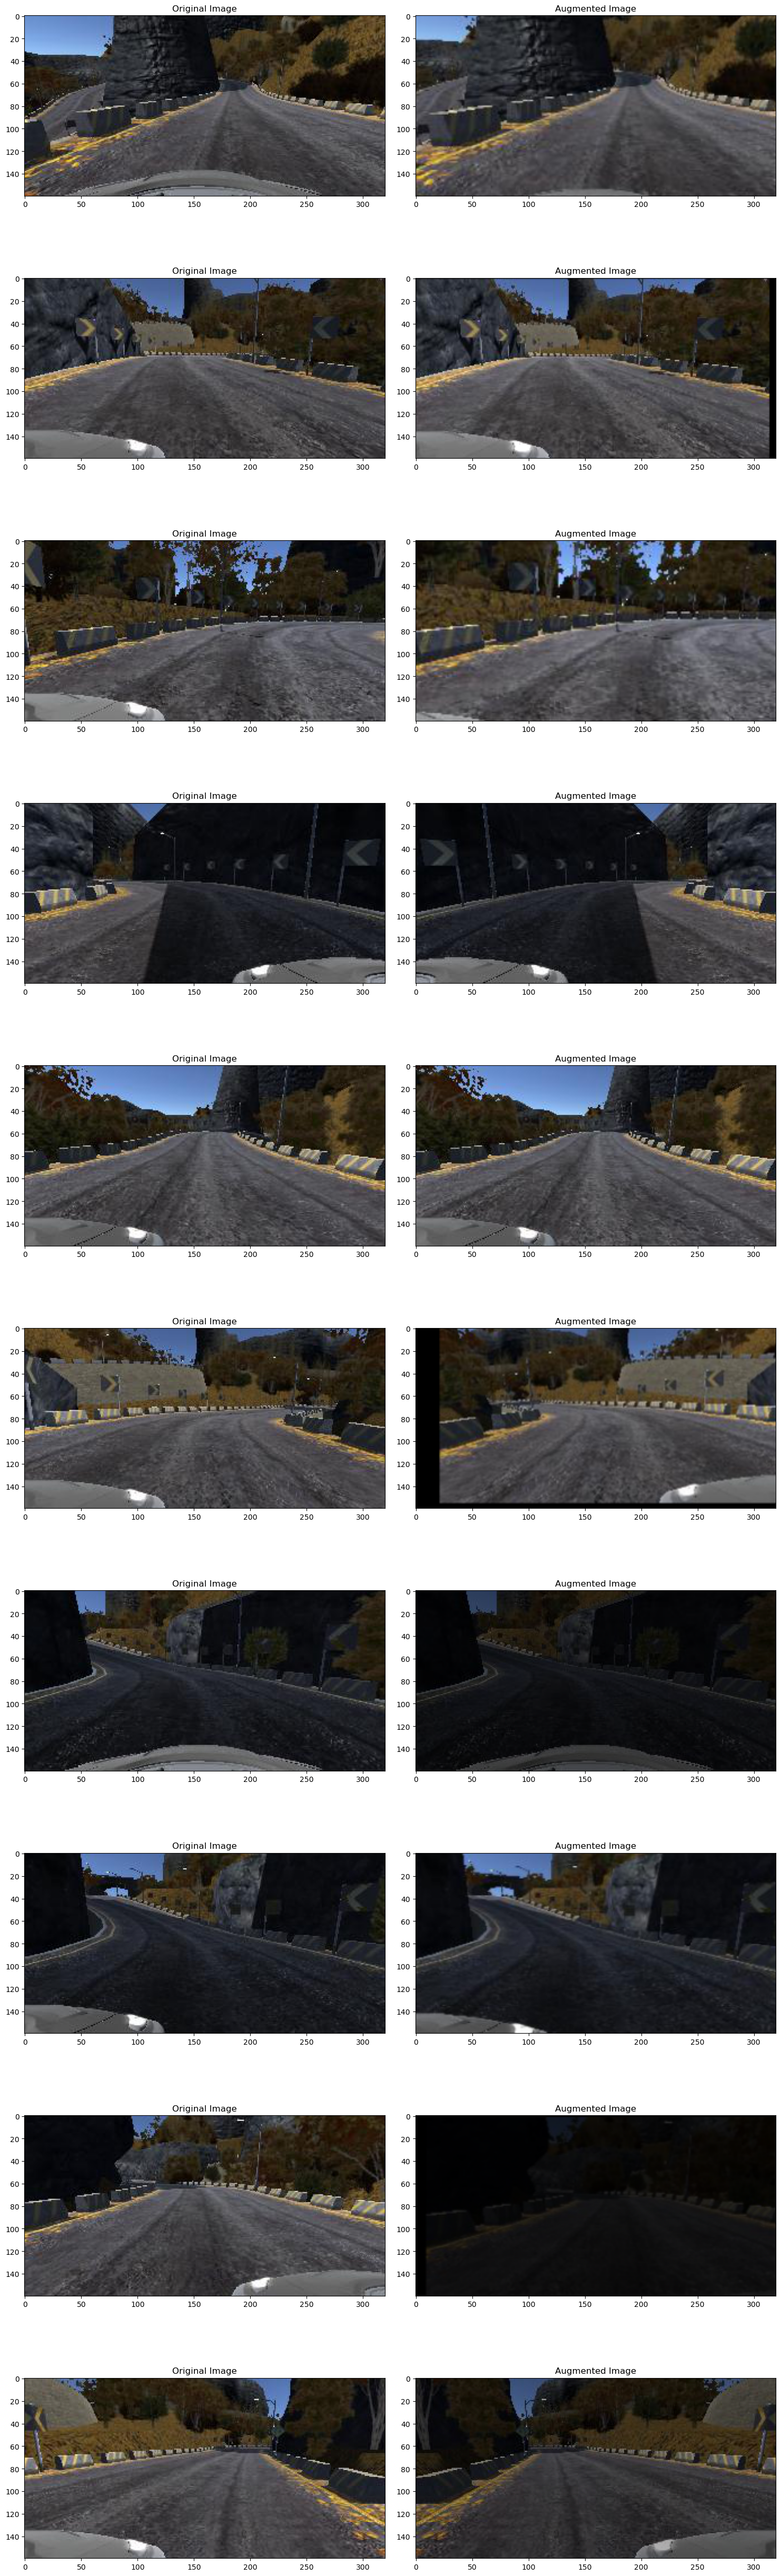

In [50]:
ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]

  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)

  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")

  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

In [51]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

Text(0.5, 1.0, 'Preprocessed Image')

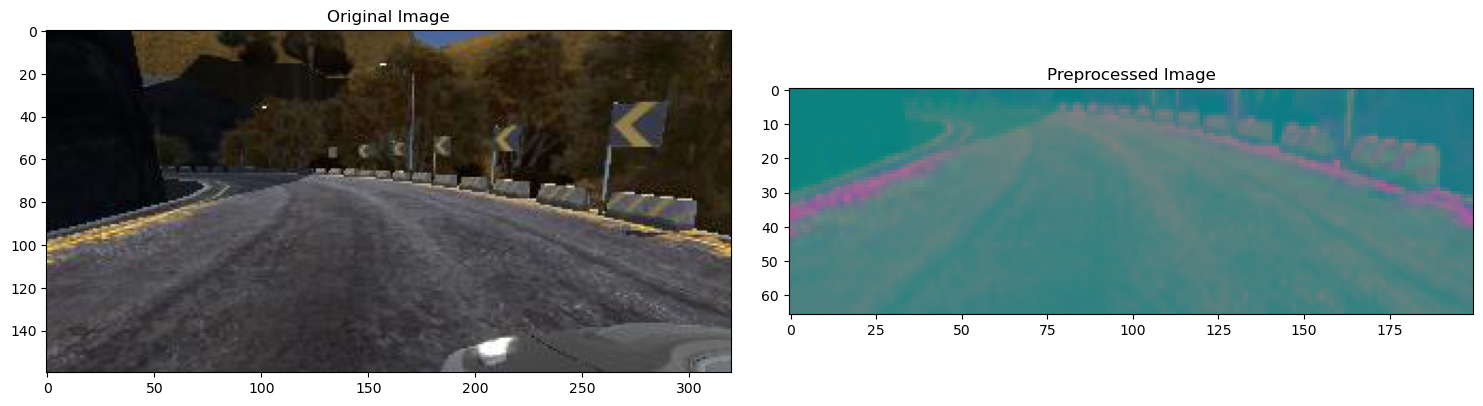

In [52]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [53]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [54]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):

  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)

      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])

      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]

      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

In [55]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

Text(0.5, 1.0, 'Validation Image')

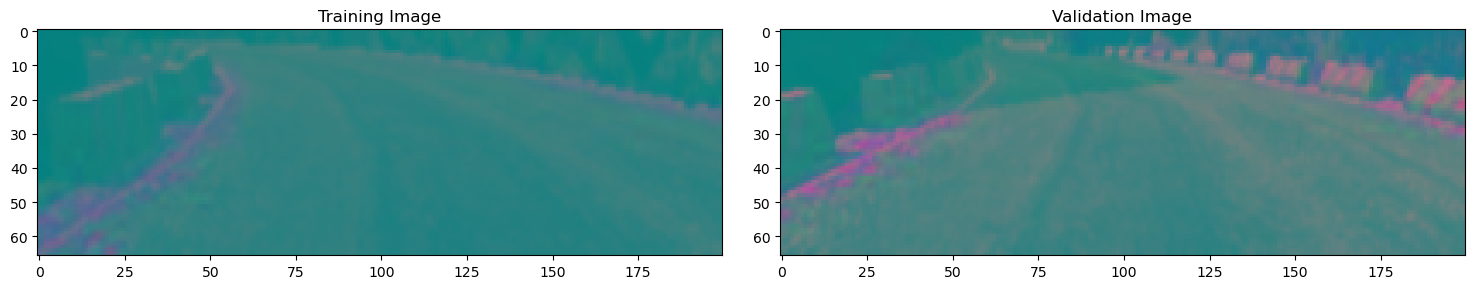

In [56]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [57]:
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(64, (5, 5), activation='elu'))
  # model.add(Conv2D(64, (3,3), activation='elu'))
#   model.add(Dropout(0.5))


  model.add(Flatten())

  model.add(Dense(100, activation = 'elu'))
#   model.add(Dropout(0.5))

  model.add(Dense(50, activation = 'elu'))
#   model.add(Dropout(0.5))

  model.add(Dense(10, activation = 'elu'))
#   model.add(Dropout(0.5))

  model.add(Dense(1))

  optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model

model = nvidia_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 31, 98, 24)        1824      
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_6 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_7 (Conv2D)           (None, 1, 18, 64)         76864     
                                                                 
 flatten_1 (Flatten)         (None, 1152)              0         
                                                                 
 dense_4 (Dense)             (None, 100)               115300    
                                                                 
 dense_5 (Dense)             (None, 50)               

In [58]:
history = model.fit(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300,
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Epoch 1/10
300/300 [==============================] - 65s 214ms/step - loss: 0.1533 - val_loss: 0.0727
Epoch 2/10
300/300 [==============================] - 72s 240ms/step - loss: 0.0765 - val_loss: 0.0593
Epoch 3/10
300/300 [==============================] - 71s 236ms/step - loss: 0.0739 - val_loss: 0.0682
Epoch 4/10
300/300 [==============================] - 64s 215ms/step - loss: 0.0723 - val_loss: 0.0739
Epoch 5/10
300/300 [==============================] - 64s 213ms/step - loss: 0.0736 - val_loss: 0.0552
Epoch 6/10
300/300 [==============================] - 62s 208ms/step - loss: 0.0657 - val_loss: 0.0566
Epoch 7/10
300/300 [==============================] - 59s 196ms/step - loss: 0.0639 - val_loss: 0.0544
Epoch 8/10
300/300 [==============================] - 44s 146ms/step - loss: 0.0609 - val_loss: 0.0526
Epoch 9/10
300/300 [==============================] - 44s 148ms/step - loss: 0.0589 - val_loss: 0.0604
Epoch 10/10
300/300 [==============================] - 44s 148ms/step - l

Text(0.5, 0, 'Epoch')

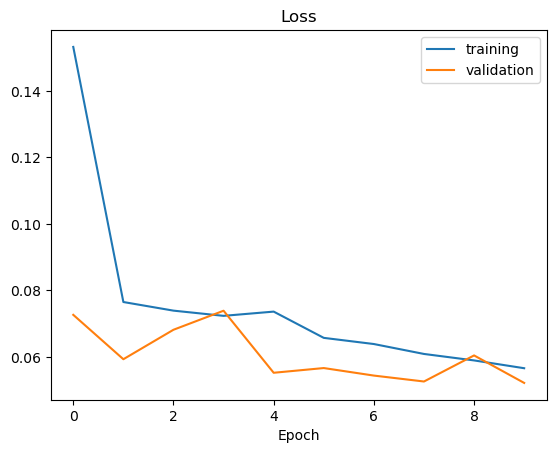

In [59]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')


In [63]:
history = model.fit(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300,
                                  epochs=1,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

300/300 [==============================] - 58s 193ms/step - loss: 0.0536 - val_loss: 0.0457


In [64]:
model.save('model/track2.h5')